In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from cancer_estimator_model import datasets

# Carregar o dataset 
df = datasets.get_integrated_dataset()
display(df.head())

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,...,NONE_EXPERIENCING,GENDER_TRANSGENDER,SEVERITY_MILD,SEVERITY_MODERATE,SEVERITY_NONE,SEVERITY_SEVERE,CONTACT_DONT_KNOW,CONTACT_NO,CONTACT_YES,COUNTRY
0,69.0,0,1.0,1.0,0.0,0.0,1,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74.0,1,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59.0,0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63.0,1,1.0,1.0,0.0,0.0,0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63.0,0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0:	learn: 0.4805945	total: 142ms	remaining: 2m 21s
1:	learn: 0.3348166	total: 145ms	remaining: 1m 12s
2:	learn: 0.2471397	total: 149ms	remaining: 49.5s
3:	learn: 0.1971676	total: 153ms	remaining: 38s
4:	learn: 0.1595190	total: 155ms	remaining: 30.8s
5:	learn: 0.1406747	total: 159ms	remaining: 26.3s
6:	learn: 0.1202956	total: 162ms	remaining: 23s
7:	learn: 0.1081134	total: 166ms	remaining: 20.6s
8:	learn: 0.0931441	total: 170ms	remaining: 18.7s
9:	learn: 0.0839078	total: 173ms	remaining: 17.2s
10:	learn: 0.0781542	total: 177ms	remaining: 15.9s
11:	learn: 0.0740504	total: 180ms	remaining: 14.8s
12:	learn: 0.0694250	total: 184ms	remaining: 14s
13:	learn: 0.0641010	total: 187ms	remaining: 13.2s
14:	learn: 0.0580542	total: 191ms	remaining: 12.5s
15:	learn: 0.0555322	total: 194ms	remaining: 11.9s
16:	learn: 0.0516268	total: 197ms	remaining: 11.4s
17:	learn: 0.0480588	total: 201ms	remaining: 11s
18:	learn: 0.0460718	total: 204ms	remaining: 10.5s
19:	learn: 0.0453858	total: 207ms	remaining: 10

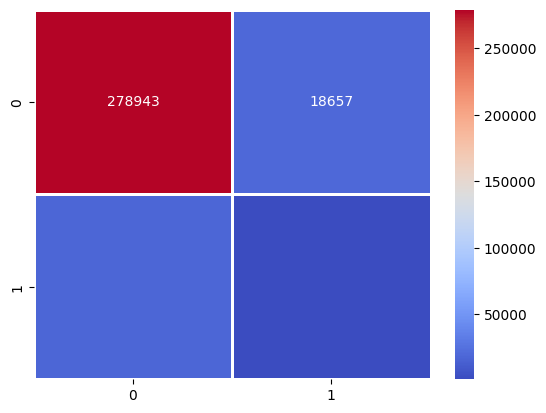

Your output file was successfully saved!


In [2]:
# Dividir o conjunto de dados em features (X) e variável alvo (y)
X = df.drop(columns=['LUNG_CANCER','COUNTRY'])
y = df['LUNG_CANCER']

# Dividir o conjunto de dados em train and test
X_train = X[X.source != 3]  # dropa os dados que tem a source 3 (dataset covid)
X_test = X[X.source == 3]   # coloca somente os dados com a source 3 no teste (dataset covid)
y_train = y[X.source != 3]  # dropa os dados que tem a source 3 (dataset covid) na target
y_test = y[X.source == 3]   # coloca somente os dados com a source 3 no teste (dataset covid) na target

# Definir colunas categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Criar o pré-processador para codificar variáveis categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Aplicar pré-processamento aos dados
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Criar o modelo CatBoostClassifier
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', class_weights=[1, 1])
#model = CatBoostClassifier(iterations=5, depth=3, learning_rate=0.1, loss_function='Logloss', class_weights=[50, 50])

# Definir o número de dobras para a validação cruzada
n_folds = 4

# Criar o objeto de validação cruzada
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Realizar a validação cruzada
scores = cross_val_score(model, X_train_encoded, y_train, cv=kf, scoring="f1")

# Exibir as pontuações de validação cruzada
print("Pontuações de validação cruzada:", scores)

# Exibir a média das pontuações de validação cruzada
print("Média das pontuações de validação cruzada:", np.mean(scores))

# Ajustar o modelo aos dados de treino completos
model.fit(X_train_encoded, y_train)

# Fazer a predição no conjunto de dados de teste
y_pred = model.predict(X_test_encoded)

# Exibir as métricas de validação do modelo (Teria que colocar o P@k aqui)
print(classification_report(y_test, y_pred))

# Matriz de confusão
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

# Criando o heatmap
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

# Salvar as predições em um arquivo CSV
output = pd.DataFrame({'Tem Cancer': y_pred})
output.to_csv('Output_cancer.csv', index=False)
print("Your output file was successfully saved!")